In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

import torch
from torch.nn import Module, Linear, ReLU, Sigmoid, Sequential, MSELoss
from torch.optim import Adam
from torch.autograd import Variable
from torch.utils.data import DataLoader

from tqdm import tqdm

In [2]:
df = pd.read_csv('marketing_campaign.csv','\t')
df.head(10)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
5,7446,1967,Master,Together,62513.0,0,1,09-09-2013,16,520,...,6,0,0,0,0,0,0,3,11,0
6,965,1971,Graduation,Divorced,55635.0,0,1,13-11-2012,34,235,...,6,0,0,0,0,0,0,3,11,0
7,6177,1985,PhD,Married,33454.0,1,0,08-05-2013,32,76,...,8,0,0,0,0,0,0,3,11,0
8,4855,1974,PhD,Together,30351.0,1,0,06-06-2013,19,14,...,9,0,0,0,0,0,0,3,11,1
9,5899,1950,PhD,Together,5648.0,1,1,13-03-2014,68,28,...,20,1,0,0,0,0,0,3,11,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [4]:
df_c = df.copy()
# Datetime
df_c['Dt_Customer'] = pd.to_datetime(df_c['Dt_Customer'])
df_c['Year_Birth'] = pd.to_datetime(df_c['Year_Birth'], format='%Y').dt.year

In [5]:
df_c.drop(columns=['Z_CostContact', 'Z_Revenue'], inplace=True)

In [6]:
df_c.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,2.662054,5.790179,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.923101,3.250958,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
def age_range(x):
    if x < 14:
        return 'Child'
    elif x < 25:
        return 'Youth'
    elif x < 64:
        return 'Adulthood'
    else:
        return 'Seniority' 

df_c['age'] = 2022 - df_c['Year_Birth']
df_c['age_range'] = df_c['age'].apply(age_range)

In [8]:
df_c.loc[df_c['age']<30, ['ID','age','age_range']]

,ID,age,age_range
46,9909,26,Adulthood
392,2669,29,Adulthood
417,5067,28,Adulthood
696,8315,27,Adulthood
747,10548,27,Adulthood
914,10619,28,Adulthood
921,4483,29,Adulthood
928,10037,29,Adulthood
995,5184,27,Adulthood
1163,6905,28,Adulthood


In [9]:
# Check Duplicated row
df_c[df_c.duplicated()]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,age,age_range


<AxesSubplot:>

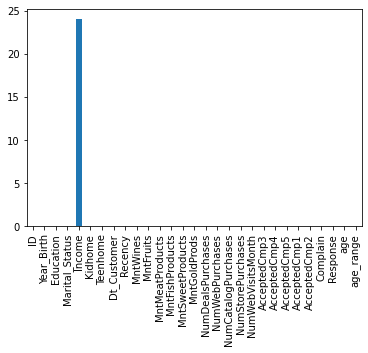

In [10]:
#check null
df_c.isnull().sum().plot.bar()

In [11]:
df_c[df_c.Income.isnull()].sample(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,age,age_range
91,9235,1957,Graduation,Single,NaN,1,1,2014-05-27,45,7,...,7,0,0,0,0,0,0,0,65,Seniority
2084,5250,1943,Master,Widow,NaN,0,0,2013-10-30,75,532,...,1,0,0,1,0,0,0,1,79,Seniority
71,10629,1973,2n Cycle,Married,NaN,1,0,2012-09-14,25,25,...,8,0,0,0,0,0,0,0,49,Adulthood
312,2437,1989,Graduation,Married,NaN,0,0,2013-03-06,69,861,...,3,0,1,0,1,0,0,0,33,Adulthood
133,1295,1963,Graduation,Married,NaN,0,1,2013-11-08,96,231,...,4,0,0,0,0,0,0,0,59,Adulthood


## Features Engineering - Handling Missing Data
### Pattern Detection
MCAR: Missing Completely at Random

MAR: Missing at Random

MNAR: Missing Not at Random

### Chi-square Test
H0: The variables are independent.

HA: The variables are not independent (meaning they are related).

In [12]:
def chi_square(cont_table):
   chi2, p, dof, ex = chi2_contingency(cont_table)
   if p > 0.05:
      print(p)
      print('Since the  𝑝-value is greater that 5%, not significant result, we fail to reject null hypothesis (H0) and the two variables are indepedent.')
   else:
      print(p)
      print('Since the  𝑝-value is lower that 5%, The variables are not independent')

In [13]:
cat_columns = df_c.select_dtypes('object').columns
cat_columns

Index(['Education', 'Marital_Status', 'age_range'], dtype='object')

In [14]:
df_c['Income_missing'] = df_c['Income']
df_c['Income_missing'] = False

# Replace True in missing data position
df_c.loc[df_c['Income'].isnull(), 'Income_missing'] = True
df_c.loc[df_c['Income'].isnull(), :]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,age,age_range,Income_missing
10,1994,1983,Graduation,Married,NaN,1,0,2013-11-15,11,5,...,0,0,0,0,0,0,0,39,Adulthood,True
27,5255,1986,Graduation,Single,NaN,1,0,2013-02-20,19,5,...,0,0,0,0,0,0,0,36,Adulthood,True
43,7281,1959,PhD,Single,NaN,0,0,2013-05-11,80,81,...,0,0,0,0,0,0,0,63,Adulthood,True
48,7244,1951,Graduation,Single,NaN,2,1,2014-01-01,96,48,...,0,0,0,0,0,0,0,71,Seniority,True
58,8557,1982,Graduation,Single,NaN,1,0,2013-06-17,57,11,...,0,0,0,0,0,0,0,40,Adulthood,True
71,10629,1973,2n Cycle,Married,NaN,1,0,2012-09-14,25,25,...,0,0,0,0,0,0,0,49,Adulthood,True
90,8996,1957,PhD,Married,NaN,2,1,2012-11-19,4,230,...,0,0,0,0,0,0,0,65,Seniority,True
91,9235,1957,Graduation,Single,NaN,1,1,2014-05-27,45,7,...,0,0,0,0,0,0,0,65,Seniority,True
92,5798,1973,Master,Together,NaN,0,0,2013-11-23,87,445,...,0,0,0,0,0,0,0,49,Adulthood,True
128,8268,1961,PhD,Married,NaN,0,1,2013-11-07,23,352,...,0,0,0,0,0,0,0,61,Adulthood,True


#### Education - Income

In [15]:
# Education - Income
edu_missing_true = df_c[df_c['Income_missing']==True].groupby(['Education'])['Education'].count()
edu_missing_false = df_c[df_c['Income_missing']==False].groupby(['Education'])['Education'].count()

print('Fasle_missing',edu_missing_false, '\nTrue_missing',edu_missing_true)

Fasle_missing Education
2n Cycle       200
Basic           54
Graduation    1116
Master         365
PhD            481
Name: Education, dtype: int64 
True_missing Education
2n Cycle       3
Graduation    11
Master         5
PhD            5
Name: Education, dtype: int64


In [16]:
cont_edu = pd.crosstab(index=df_c['Education'], columns=df_c['Income_missing'])
cont_edu

Income_missing,False,True
Education,,
2n Cycle,200,3
Basic,54,0
Graduation,1116,11
Master,365,5
PhD,481,5


In [17]:
chi_square(cont_edu)

0.8648017103773101
Since the  𝑝-value is greater that 5%, not significant result, we fail to reject null hypothesis (H0) and the two variables are indepedent.


#### Marital_Status - Income

In [18]:
cont_marr = pd.crosstab(index=df_c['Marital_Status'], columns=df_c['Income_missing'])
cont_marr

Income_missing,False,True
Marital_Status,,
Absurd,2,0
Alone,3,0
Divorced,232,0
Married,857,7
Single,471,9
Together,573,7
Widow,76,1
YOLO,2,0


In [19]:
chi_square(cont_marr)

0.5158103507860547
Since the  𝑝-value is greater that 5%, not significant result, we fail to reject null hypothesis (H0) and the two variables are indepedent.


#### Age_range - Income

In [20]:
age_cont = pd.crosstab(index=df_c['age_range'], columns=df_c['Income_missing'])
age_cont

Income_missing,False,True
age_range,,
Adulthood,1704,17
Seniority,512,7


In [21]:
chi_square(age_cont)

0.6477550432268537
Since the  𝑝-value is greater that 5%, not significant result, we fail to reject null hypothesis (H0) and the two variables are indepedent.


#### AcceptedCmp - Income

In [22]:
for i in range(1,6):
    acc_cont = pd.crosstab(index=df_c['AcceptedCmp{0}'.format(i)], columns=df_c['Income_missing'])
    chi_square(acc_cont)

0.9713928336997263
Since the  𝑝-value is greater that 5%, not significant result, we fail to reject null hypothesis (H0) and the two variables are indepedent.
0.7498679214515649
Since the  𝑝-value is greater that 5%, not significant result, we fail to reject null hypothesis (H0) and the two variables are indepedent.
0.32473476038456756
Since the  𝑝-value is greater that 5%, not significant result, we fail to reject null hypothesis (H0) and the two variables are indepedent.
0.5786973367774413
Since the  𝑝-value is greater that 5%, not significant result, we fail to reject null hypothesis (H0) and the two variables are indepedent.
0.8456297121311362
Since the  𝑝-value is greater that 5%, not significant result, we fail to reject null hypothesis (H0) and the two variables are indepedent.


#### จากการทดสอบ Chi-square ของ Category Data พบว่า missing data ที่เกิดขึ้นเป็นประเภท MCAR ไม่มี Pattern ในการหายไปของข้อมูล

### Imputation

<AxesSubplot:xlabel='Education', ylabel='Income'>

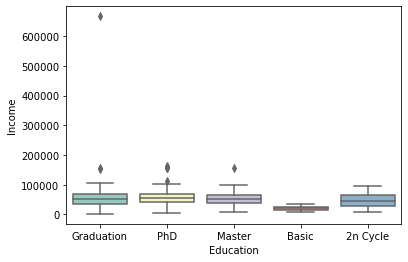

In [23]:
sns.boxplot(data=df_c, x='Education', y='Income', palette='Set3')

##### เนื่องจากมี Outliers ดังนั้นจึงตัดสินใจใช้ Median ที่ sensitive ต่อ Outlier น้อยกว่า

In [24]:
g_edu_median = df_c.groupby(['Education'], as_index=False)['Income'].median()
g_edu_median
edu_level = g_edu_median.Education.unique()

# Imputation
for edu in edu_level:
    df_c.loc[(df_c['Education']==edu)&(df_c['Income'].isnull()),'Income'] = g_edu_median.loc[g_edu_median['Education']==edu, 'Income'].values[0]

In [25]:
df_c[df_c.Income.isnull()]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,age,age_range,Income_missing


## Features Engineering - Handling Outliers

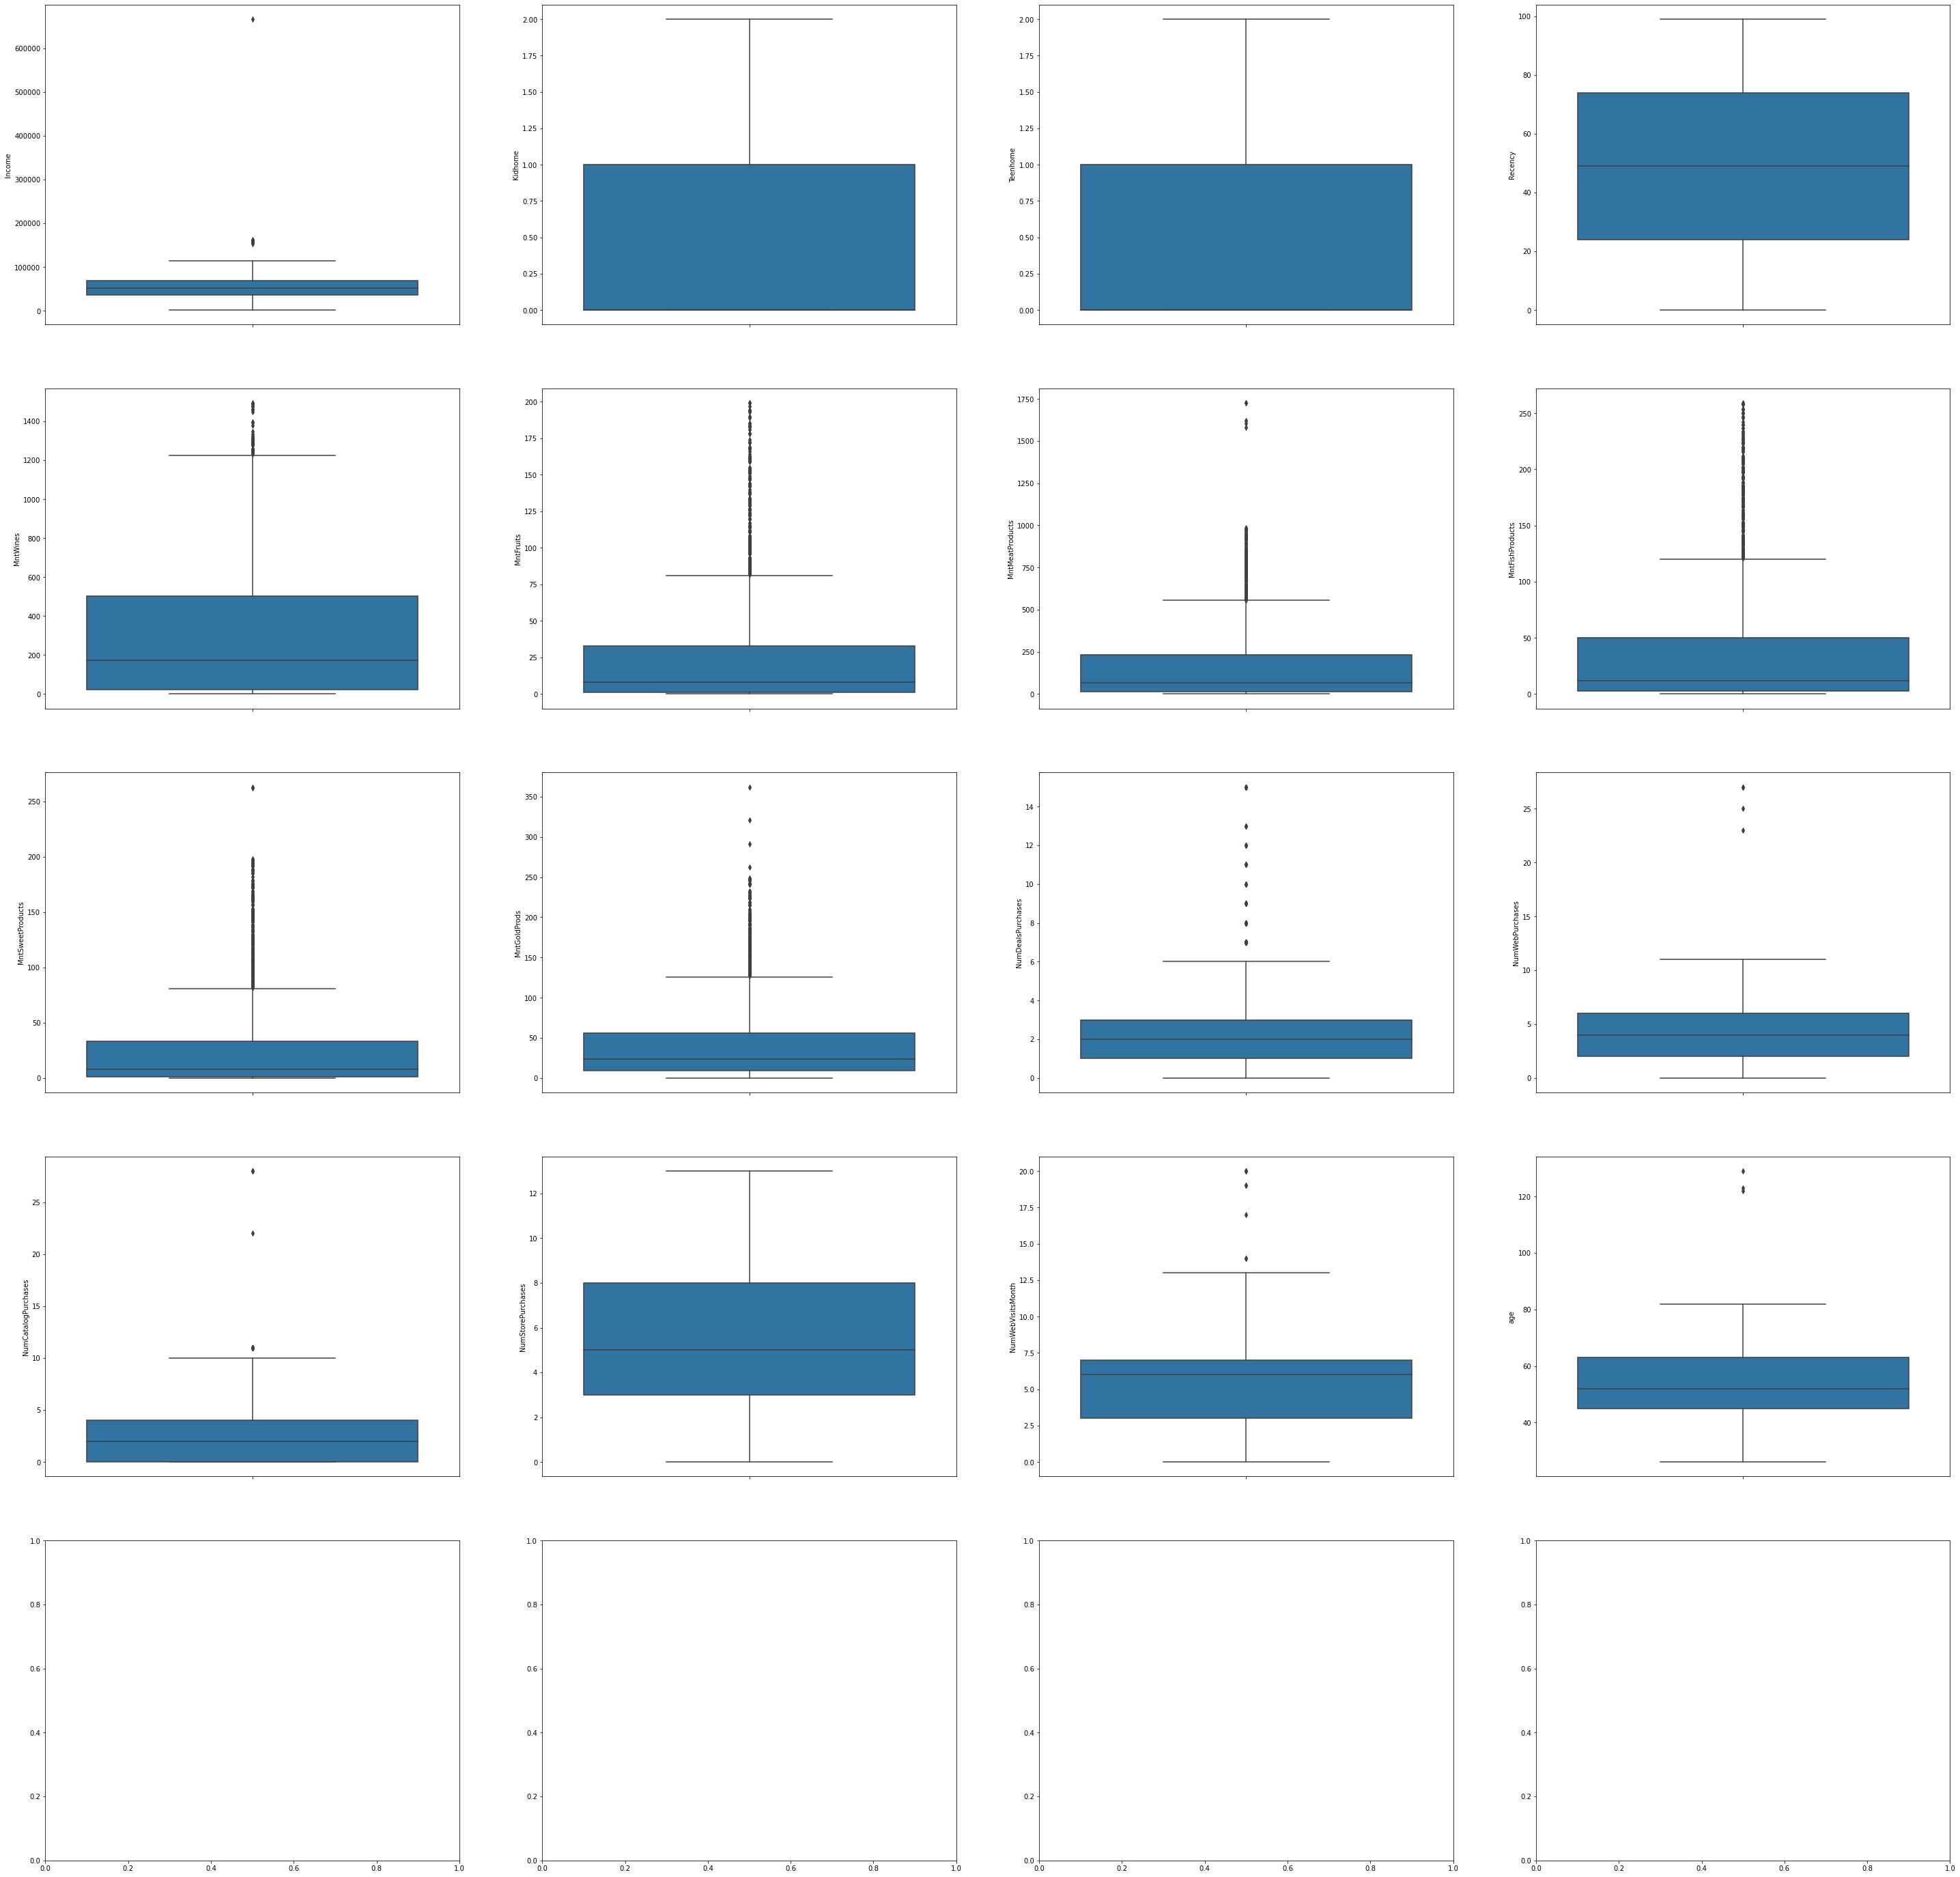

In [26]:
df_t = df_c.copy()
df_t['Year_Birth'] = df_t['Year_Birth'].astype('str')
df_t.drop(columns=['Response'], inplace=True)

# category columns in dataset
astype_col = ['ID','Complain','AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5']
for col in astype_col:
    df_t[col] = df_t[col].astype('object')

col_num = df_t.select_dtypes('number').columns
fig, axes = plt.subplots(5, 4, figsize=(50,50))
axes = axes.flatten()
for col, ax in zip(col_num, axes):
    sns.boxplot(data=df_t, y=col, ax=ax)

In [27]:
# Age
age_q25 = df_t.age.quantile(0.25) 
age_q75 = df_t.age.quantile(0.75)
IQR = age_q75-age_q25

lower_b = age_q25 - (1.5*IQR)
upper_b = age_q75 + (1.5*IQR)

# the outlier is capped at a certain value above the 90th percentile value
df_c.loc[df_c['age']> upper_b,'age'] = upper_b

In [28]:
df_c.loc[df_c['age']>upper_b,:]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,age,age_range,Income_missing


## Feature Extraction

In [29]:
df_c['Mnttotal'] = df_c['MntWines'] + df_c['MntFruits'] + df_c['MntMeatProducts'] + df_c['MntFishProducts'] + df_c['MntSweetProducts'] + df_c['MntGoldProds']
df_c['acceptedCmp'] = df_c['AcceptedCmp1'] + df_c['AcceptedCmp2'] + df_c['AcceptedCmp3'] + df_c['AcceptedCmp4'] + df_c['AcceptedCmp5']
df_c['has_child'] = df_c['Kidhome'].apply(lambda x : '1' if x>0 else '0')
df_c['has_teen'] = df_c['Teenhome'].apply(lambda x : '1' if x>0 else '0')
df_c['#children'] = df_c['Teenhome'] + df_c['Kidhome']

single_status = ['Single', 'Divorced', 'Widow', 'Alone', 'Absurd', 'YOLO']
df_c['Is_single'] = df_c['Marital_Status'].apply(lambda x: '1' if x in single_status else '0')

df_c['family_size'] = df_c['Is_single'].replace({'1':1, '0':2}) + df_c['Kidhome'] + df_c['Teenhome']


In [30]:
df_c

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,age,age_range,Income_missing,Mnttotal,acceptedCmp,has_child,has_teen,#children,Is_single,family_size
0,5524,1957,Graduation,Single,58138.0,0,0,2012-04-09,58,635,...,65.0,Seniority,False,1617,0,0,0,0,1,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-08-03,38,11,...,68.0,Seniority,False,27,0,1,1,2,1,3
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,57.0,Adulthood,False,776,0,0,0,0,0,2
3,6182,1984,Graduation,Together,26646.0,1,0,2014-10-02,26,11,...,38.0,Adulthood,False,53,0,1,0,1,0,3
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,41.0,Adulthood,False,422,0,1,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,...,55.0,Adulthood,False,1341,0,0,1,1,0,3
2236,4001,1946,PhD,Together,64014.0,2,1,2014-10-06,56,406,...,76.0,Seniority,False,444,1,1,1,3,0,5
2237,7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,...,41.0,Adulthood,False,1241,1,0,0,0,1,1
2238,8235,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,...,66.0,Seniority,False,843,0,0,1,1,0,3


## EDA

In [31]:
astype_col = ['ID','Complain','AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response']
for col in astype_col:
    df_c[col] = df_c[col].astype('str')

### Pareto

In [32]:
# Pareto 80:20 - Total amount
data = df_c.sort_values(by=['Mnttotal'], ascending=False)
data['cumperc_mnttotal'] = data['Mnttotal'].cumsum() / data['Mnttotal'].sum() * 100


data_mnt_total_80 = data[data['cumperc_mnttotal']<=80]
data_mnt_total_80

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,age_range,Income_missing,Mnttotal,acceptedCmp,has_child,has_teen,#children,Is_single,family_size,cumperc_mnttotal
1572,5350,1991,Master,Single,90638.0,0,0,2014-02-13,29,1156,...,Adulthood,False,2525,1,0,0,0,1,1,0.186074
1179,5735,1991,Master,Single,90638.0,0,0,2014-02-13,29,1156,...,Adulthood,False,2525,1,0,0,0,1,1,0.372148
1492,1763,1988,Graduation,Together,87679.0,0,0,2013-07-27,62,1259,...,Adulthood,False,2524,3,0,0,0,0,2,0.558148
987,4580,1969,Graduation,Married,75759.0,0,0,2013-10-25,46,1394,...,Adulthood,False,2486,3,0,0,0,0,2,0.741348
1052,4475,1949,PhD,Married,69098.0,0,0,2013-02-16,82,1315,...,Seniority,False,2440,0,0,0,0,0,2,0.921158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,7446,1967,Master,Together,62513.0,0,1,2013-09-09,16,520,...,Adulthood,False,716,0,0,1,1,0,3,79.743078
2071,2712,1956,Graduation,Married,71866.0,0,1,2013-12-25,85,184,...,Seniority,False,715,0,0,1,1,0,3,79.795768
222,4785,1970,PhD,Together,77622.0,0,2,2014-04-14,3,520,...,Adulthood,False,714,0,0,1,2,0,4,79.848385
1243,7718,1947,Master,Together,66000.0,0,0,2014-04-20,36,244,...,Seniority,False,711,0,0,0,0,0,2,79.900780


[Text(0.5, 1.0, 'Count')]

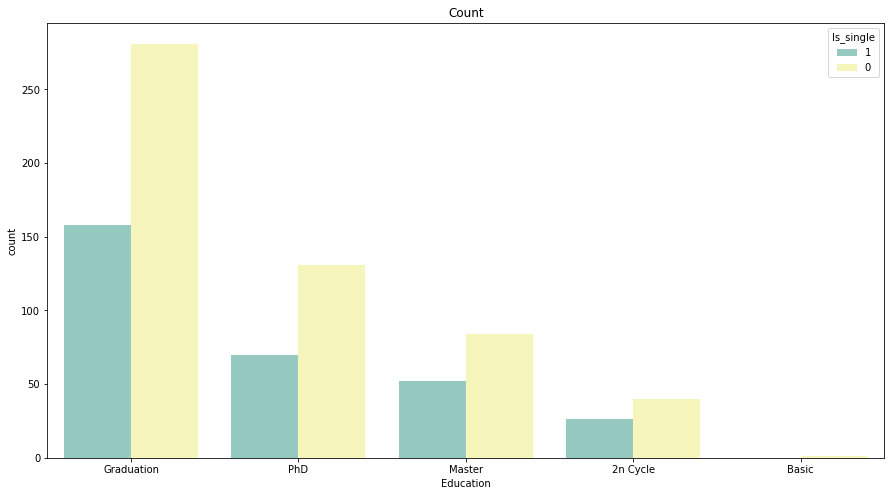

In [33]:
fig, ax = plt.subplots(figsize=(15,8))
sns.countplot(
    data=data_mnt_total_80, 
    x='Education',
    hue='Is_single', 
    order=data_mnt_total_80['Education'].value_counts().index ,
    palette='Set3',
    ax=ax
    ).set(title='Count')

In [34]:
d_sum = data_mnt_total_80.groupby(['Education', 'Is_single', 'age_range'], as_index=False)['Mnttotal'].sum().sort_values(by=['Mnttotal'], ascending=False)
d_sum

,Education,Is_single,age_range,Mnttotal
5,Graduation,0,Adulthood,270891
7,Graduation,1,Adulthood,145593
13,PhD,0,Adulthood,122731
6,Graduation,0,Seniority,90471
15,PhD,1,Adulthood,64844
9,Master,0,Adulthood,62352
8,Graduation,1,Seniority,55001
11,Master,1,Adulthood,54691
14,PhD,0,Seniority,52263
10,Master,0,Seniority,41625


[Text(0.5, 1.0, 'Sum Total Amount')]

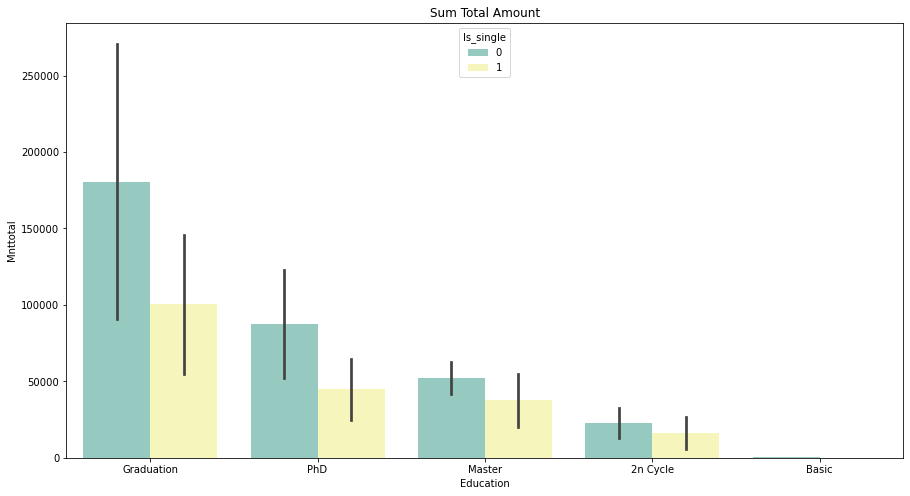

In [35]:
fig, ax = plt.subplots(figsize=(15,8))
sns.barplot(
    data=d_sum, 
    x='Education', 
    y='Mnttotal', 
    hue='Is_single',
    palette='Set3'
    ).set(title='Sum Total Amount')

[Text(0.5, 1.0, 'Total Amount Dis.')]

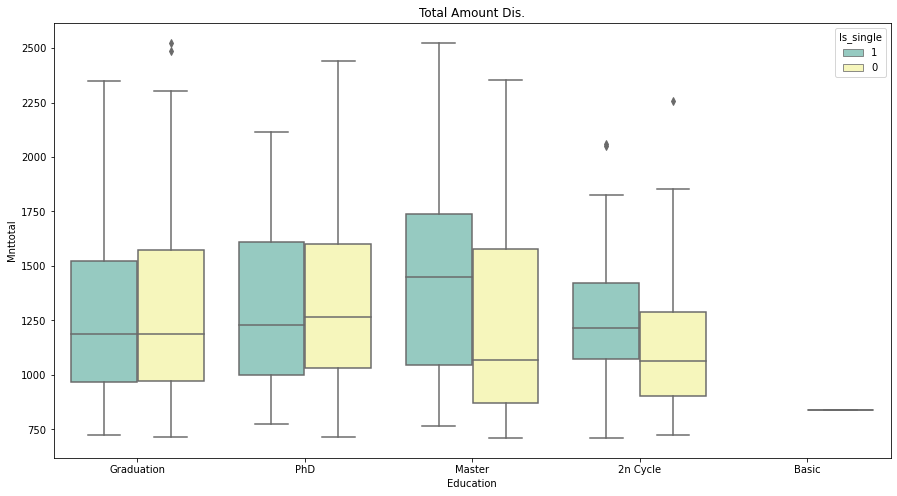

In [36]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(
    data=data_mnt_total_80, 
    x='Education', 
    y='Mnttotal', 
    palette='Set3',
    hue='Is_single',
    order=data_mnt_total_80['Education'].value_counts().index,
    ).set(title='Total Amount Dis.')

[Text(0.5, 1.0, 'Count')]

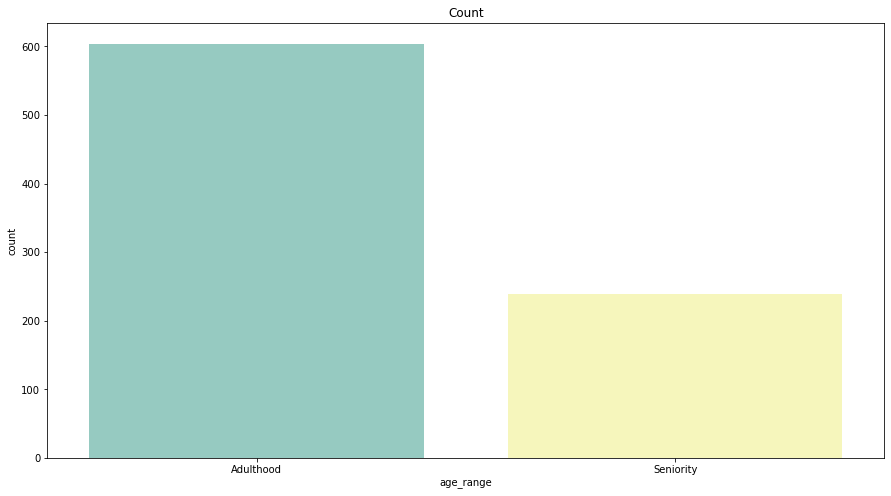

In [37]:
fig, ax = plt.subplots(figsize=(15,8))

sns.countplot(
    data=data_mnt_total_80,
    x='age_range',
    palette='Set3'
).set(title='Count')

[Text(0.5, 1.0, 'Sum Total Amount')]

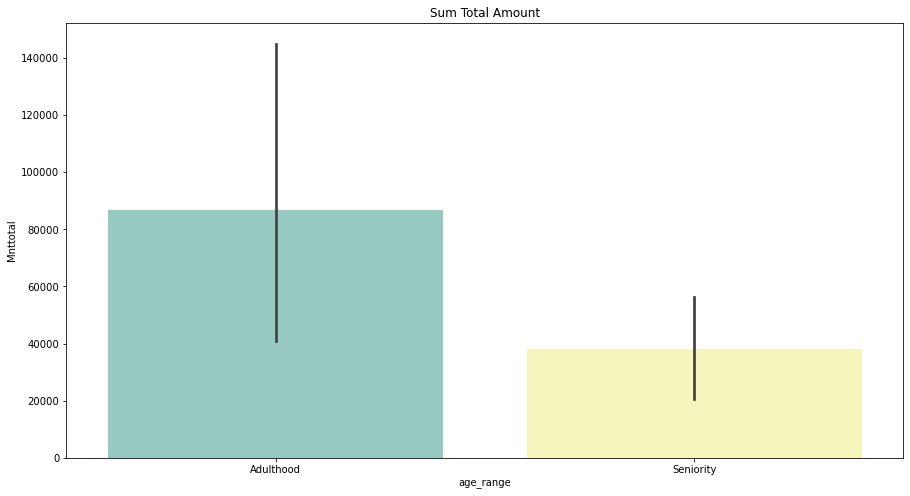

In [38]:
fig, ax = plt.subplots(figsize=(15,8))
sns.barplot(
    data=d_sum,
    x='age_range',
    y='Mnttotal',
    palette='Set3',
).set(title='Sum Total Amount')

[Text(0.5, 1.0, 'Total Amount Dis.')]

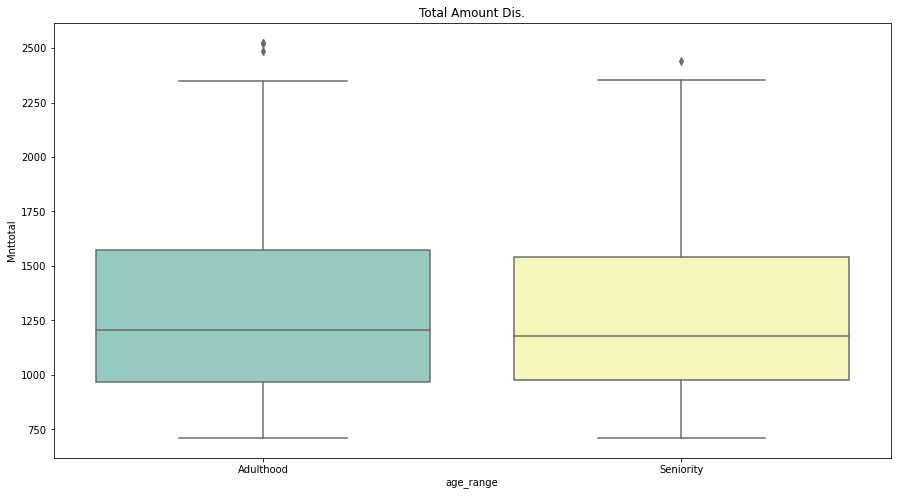

In [39]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(
    data=data_mnt_total_80,
    x='age_range',
    y='Mnttotal',
    palette='Set3',
).set(title='Total Amount Dis.')

[Text(0.5, 1.0, 'Income')]

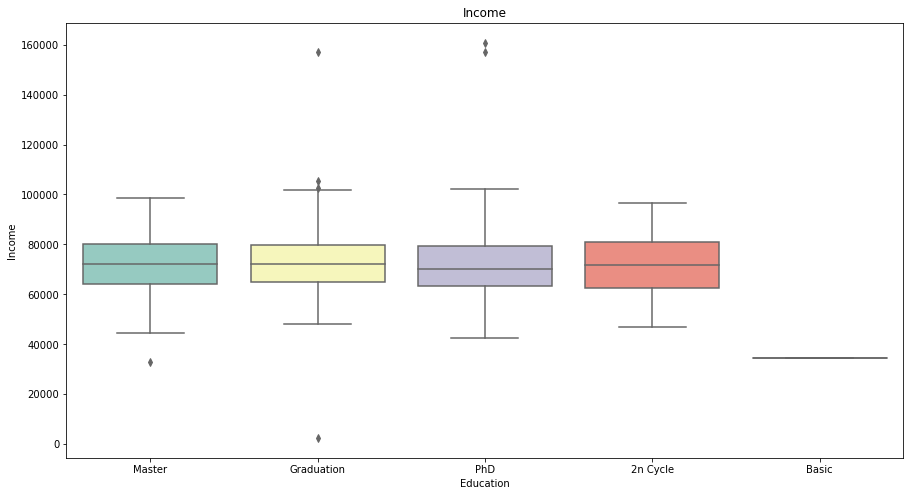

In [40]:
fig, ax = plt.subplots(figsize=(15,8))

sns.boxplot(
    data=data_mnt_total_80,
    x='Education',
    y='Income',
    palette='Set3'
).set(title='Income')

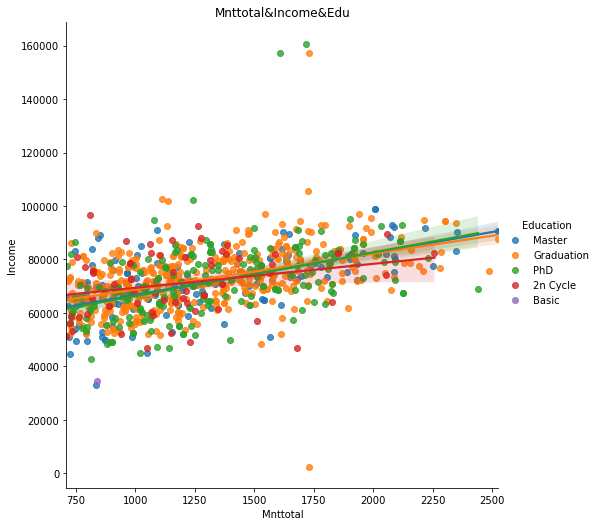

In [41]:
sns.lmplot(
    data=data_mnt_total_80,
    x='Mnttotal',
    y='Income',
    hue='Education',
    height=7,
).set(title='Mnttotal&Income&Edu')

[Text(0.5, 1.0, 'Mnttotal_child')]

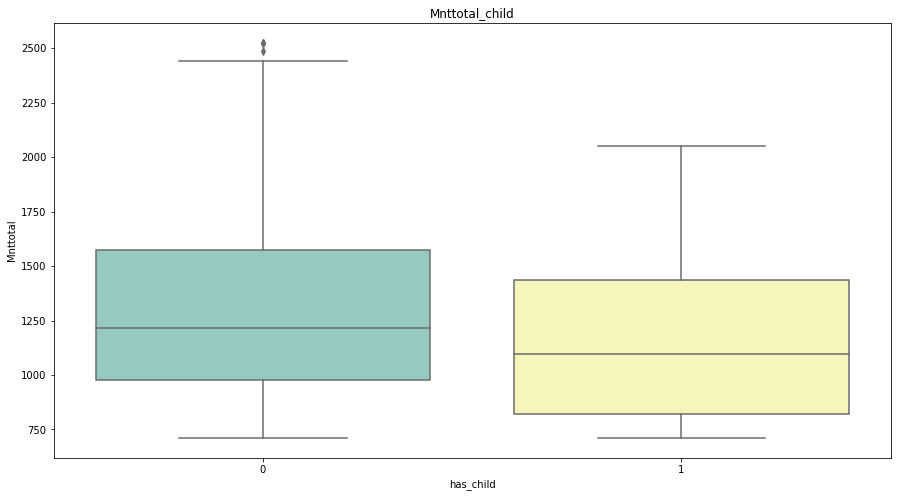

In [42]:
fig, ax= plt.subplots(figsize=(15,8))
sns.boxplot(
    data=data_mnt_total_80,
    x='has_child',
    y='Mnttotal',
    palette='Set3'
).set(title='Mnttotal_child')

[Text(0.5, 1.0, 'Mnttotal_teenager')]

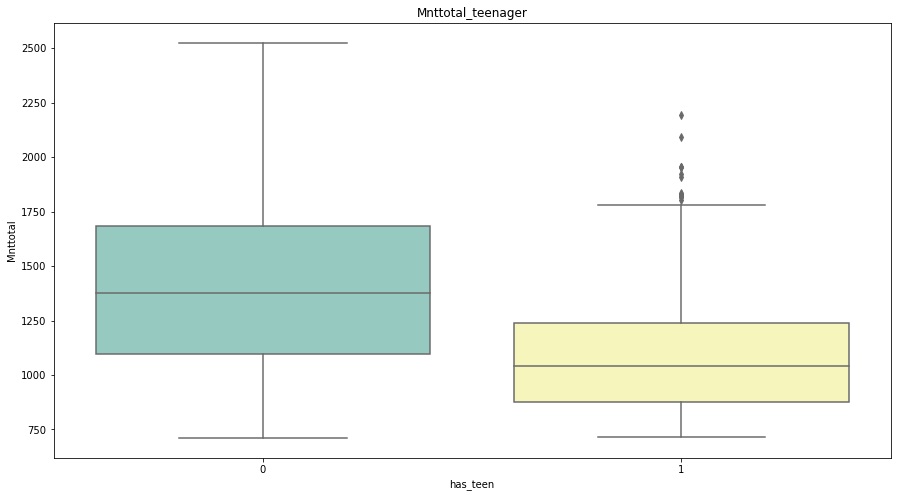

In [43]:
fig, ax= plt.subplots(figsize=(15,8))
sns.boxplot(
    data=data_mnt_total_80,
    x='has_teen',
    y='Mnttotal',
    palette='Set3'
).set(title='Mnttotal_teenager')

[Text(0.5, 1.0, 'familysize')]

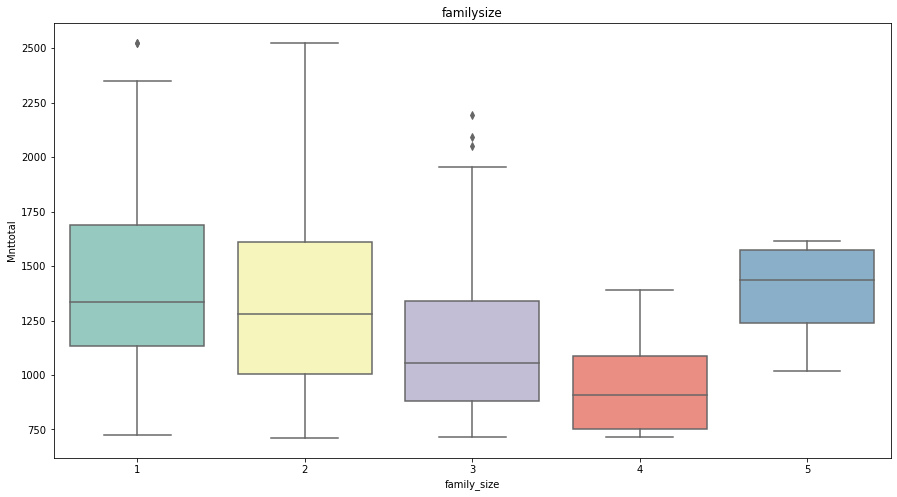

In [44]:
fig, ax= plt.subplots(figsize=(15,8))
sns.boxplot(
    data=data_mnt_total_80,
    x='family_size',
    y='Mnttotal',
    palette='Set3'
).set(title='familysize')

## Customer Segmentation Clustering

In [45]:
df_x = df_c.copy()
col_drop  = df_x.select_dtypes(include=['object', 'bool', 'datetime']).columns
df_x.drop(columns=col_drop, inplace=True)
df_x.drop(columns='Year_Birth', inplace=True)

### Scale the continuous features

In [46]:
scaler = StandardScaler()
data = scaler.fit_transform(df_x)

df_sc = pd.DataFrame(data, columns=df_x.columns)
df_sc

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,age,Mnttotal,acceptedCmp,#children,family_size
0,0.235501,-0.825218,-0.929894,0.307039,0.983781,1.551577,1.679702,2.462147,1.476500,0.843207,0.349414,1.409304,2.510890,-0.550785,0.693904,1.007064,1.679417,-0.439037,-1.264505,-1.759115
1,-0.235628,1.032559,0.906934,-0.383664,-0.870479,-0.636301,-0.713225,-0.650449,-0.631503,-0.729006,-0.168236,-1.110409,-0.568720,-1.166125,-0.130463,1.261969,-0.961275,-0.439037,1.396361,0.446548
2,0.773780,-0.825218,-0.929894,-0.798086,0.362723,0.570804,-0.177032,1.345274,-0.146905,-0.038766,-0.685887,1.409304,-0.226541,1.295237,-0.542647,0.327318,0.282673,-0.439037,-1.264505,-0.656283
3,-1.022495,1.032559,-0.929894,-0.798086,-0.870479,-0.560857,-0.651187,-0.503974,-0.583043,-0.748179,-0.168236,-0.750450,-0.910898,-0.550785,0.281720,-1.287080,-0.918094,-0.439037,0.065928,0.446548
4,0.241693,1.032559,-0.929894,1.550305,-0.389085,0.419916,-0.216914,0.155164,-0.001525,-0.556446,1.384715,0.329427,0.115638,0.064556,-0.130463,-1.032175,-0.305254,-0.439037,0.065928,0.446548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,0.358736,-0.825218,0.906934,-0.107383,1.203678,0.419916,0.066692,0.081926,2.203398,3.891766,-0.168236,1.769263,0.115638,-0.550785,-0.130463,0.157381,1.221032,-0.439037,0.065928,0.446548
2236,0.470227,2.890335,0.906934,0.237969,0.303291,-0.661449,-0.606873,-0.687068,-0.655733,-0.690659,2.420015,1.409304,-0.226541,-0.243114,0.693904,1.941715,-0.268717,1.035390,2.726794,2.652211
2237,0.189283,-0.825218,-0.929894,1.446700,1.795020,0.545656,0.221789,-0.101168,-0.364974,-0.383886,-0.685887,-0.750450,0.115638,2.218248,0.281720,-1.032175,1.054951,1.035390,-1.264505,-1.759115
2238,0.679187,-0.825218,0.906934,-1.419719,0.368666,0.092992,0.208495,0.777683,0.071165,0.325527,-0.168236,0.689386,0.799996,1.295237,-0.954831,1.092032,0.393948,-0.439037,0.065928,0.446548


In [47]:
data.shape

(2240, 20)

In [48]:
len(df_sc.columns)

20

### Deep fully-connected AutoEncoder

In [49]:
class AutoEncoder(Module):
    def __init__(self):
        super().__init__()

        self.encoder = Sequential(
            Linear(20, 20),
            ReLU(),
            Linear(20, 15),
            ReLU(),
            Linear(15, 5),
            ReLU(),            
        )

        self.decoder = Sequential(
            Linear(5, 15),
            ReLU(),
            Linear(15, 15),
            ReLU(),
            Linear(15, 20),
            Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode_data(self, x):
        encoded_data = self.encoder(x)
        return encoded_data


In [50]:
AE = AutoEncoder()

# Validation using MSE Loss function
loss_function = MSELoss()
  
# Using an Adam Optimizer with lr = 0.1
optimizer = Adam(AE.parameters(), lr = 1e-3, weight_decay = 1e-8)

In [51]:
data_loader = DataLoader(dataset = data, batch_size = 16, shuffle = True)

In [52]:
for i in data_loader:
    print(i)
    print('shape', i.shape)
    break

tensor([[ 0.0452, -0.8252,  0.9069, -0.5218,  1.7594, -0.4100, -0.2922, -0.4490,
         -0.4134, -0.1922,  1.9024, -0.0305, -0.2265,  0.9876,  1.5183, -0.0126,
          0.7610,  1.0354,  0.0659,  0.4465],
        [-0.7048,  1.0326,  0.9069, -1.4197, -0.3118,  0.1684, -0.4739, -0.5406,
         -0.5830, -0.5564,  1.3847,  0.3294, -0.2265, -0.2431,  1.1061, -0.1825,
         -0.4780, -0.4390,  1.3964,  1.5494],
        [-0.5576,  2.8903,  0.9069,  1.6194, -0.8972, -0.6614, -0.7177, -0.6504,
         -0.6557, -0.8249, -0.6859, -1.4704, -0.9109, -0.8585, -1.3670,  0.8371,
         -0.9895, -0.4390,  2.7268,  2.6522],
        [ 0.4633, -0.8252,  0.9069,  0.5143,  0.9838, -0.2842, -0.2967, -0.3209,
         -0.4861,  1.6677, -0.6859,  1.7693,  0.1156,  0.9876,  0.2817,  0.0724,
          0.5019, -0.4390,  0.0659, -0.6563],
        [ 0.5039, -0.8252, -0.9299,  0.9977,  0.7490, -0.3094,  2.4375,  3.1579,
         -0.6557, -0.0196, -0.6859,  1.0493,  0.8000,  1.2952, -0.5426,  1.0920,
      

In [53]:
EPOCHS = 100
outputs = []
losses = []

for epoch in tqdm(range(EPOCHS), 'AutoEncoder'):
    for d in data_loader:
        reconstructed = AE(d.float())
        loss = Variable(loss_function(reconstructed.long(), d), requires_grad=True)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss)
    outputs.append((EPOCHS, d, reconstructed))

AutoEncoder: 100%|██████████| 100/100 [00:06<00:00, 14.73it/s]


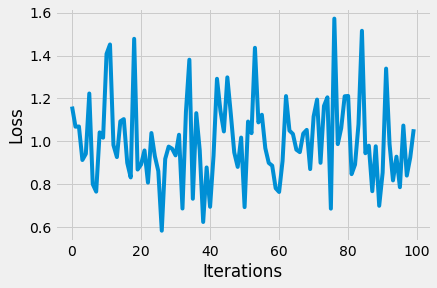

In [54]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
  
# Plotting the last 100 values
plt.plot(losses[-EPOCHS:])

### Clustering Alg

In [55]:
# Encode data_tensor
data_tensor = torch.from_numpy(data)
data_encoded = AE.encode_data(data_tensor.float())

In [95]:
silhouette_scores = []
for k in range(2,10,1): 
    model = AgglomerativeClustering(n_clusters=k)
    cluster = model.fit_predict(data_encoded.detach().numpy())
    score = silhouette_score(data_encoded.detach().numpy(), cluster)
    scores={'K':k, 'silh_score':score}
    silhouette_scores.append(scores)
silhouette_scores

[{'K': 2, 'silh_score': 0.37563878},
 {'K': 3, 'silh_score': 0.28524196},
 {'K': 4, 'silh_score': 0.2700431},
 {'K': 5, 'silh_score': 0.2386965},
 {'K': 6, 'silh_score': 0.22526492},
 {'K': 7, 'silh_score': 0.19357842},
 {'K': 8, 'silh_score': 0.17973393},
 {'K': 9, 'silh_score': 0.18175995}]

<AxesSubplot:xlabel='K', ylabel='silh_score'>

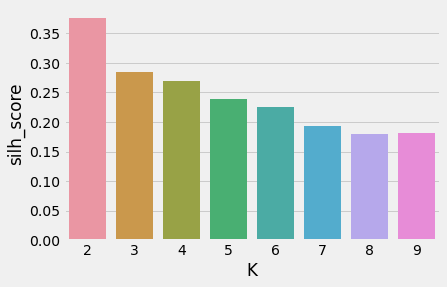

In [99]:
df_sh = pd.DataFrame(silhouette_scores)
sns.barplot(
    data=df_sh,
    x='K',
    y='silh_score'
)

#### Select k = 2

In [84]:
model = AgglomerativeClustering(n_clusters=2)
cluster = model.fit_predict(data_encoded.detach().numpy())
df_c['label'] = cluster
df_c

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,age_range,Income_missing,Mnttotal,acceptedCmp,has_child,has_teen,#children,Is_single,family_size,label
0,5524,1957,Graduation,Single,58138.0,0,0,2012-04-09,58,635,...,Seniority,False,1617,0,0,0,0,1,1,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-08-03,38,11,...,Seniority,False,27,0,1,1,2,1,3,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,Adulthood,False,776,0,0,0,0,0,2,1
3,6182,1984,Graduation,Together,26646.0,1,0,2014-10-02,26,11,...,Adulthood,False,53,0,1,0,1,0,3,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,Adulthood,False,422,0,1,0,1,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,...,Adulthood,False,1341,0,0,1,1,0,3,0
2236,4001,1946,PhD,Together,64014.0,2,1,2014-10-06,56,406,...,Seniority,False,444,1,1,1,3,0,5,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,...,Adulthood,False,1241,1,0,0,0,1,1,1
2238,8235,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,...,Seniority,False,843,0,0,1,1,0,3,0


In [85]:
df_c['label'].value_counts()

0    1737
1     503
Name: label, dtype: int64

In [86]:
data_r = pd.DataFrame(data_encoded.tolist())
data_r['label'] = cluster
data_r

,0,1,2,3,4,label
0,0.200557,0.187966,0.000000,0.288234,0.0,1
1,0.211547,0.033174,0.042234,0.325441,0.0,0
2,0.217925,0.192710,0.000000,0.268223,0.0,1
3,0.321126,0.117849,0.027656,0.262513,0.0,0
4,0.181827,0.181968,0.000000,0.268566,0.0,1
...,...,...,...,...,...,...
2235,0.226755,0.061499,0.000000,0.274043,0.0,0
2236,0.218473,0.085084,0.000000,0.358858,0.0,0
2237,0.253833,0.238830,0.000000,0.242641,0.0,1
2238,0.216701,0.101557,0.027033,0.266609,0.0,0


<AxesSubplot:xlabel='1', ylabel='3'>

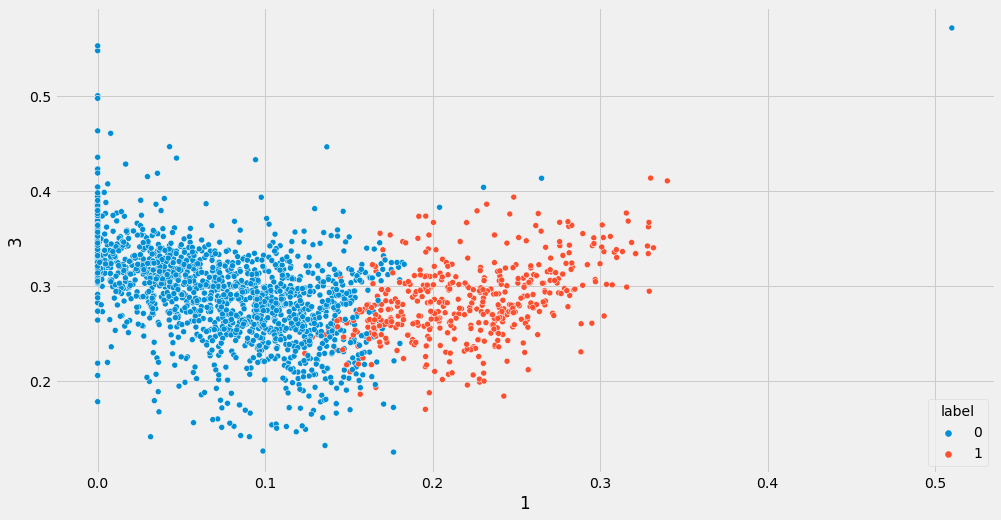

In [91]:
fig, ax = plt.subplots(figsize=(15,8))
sns.scatterplot(
    data=data_r,
    x=1,
    y=3,
    hue='label'
)

## EVALUATING MODELS

In [128]:
col_num

Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'age'],
      dtype='object')

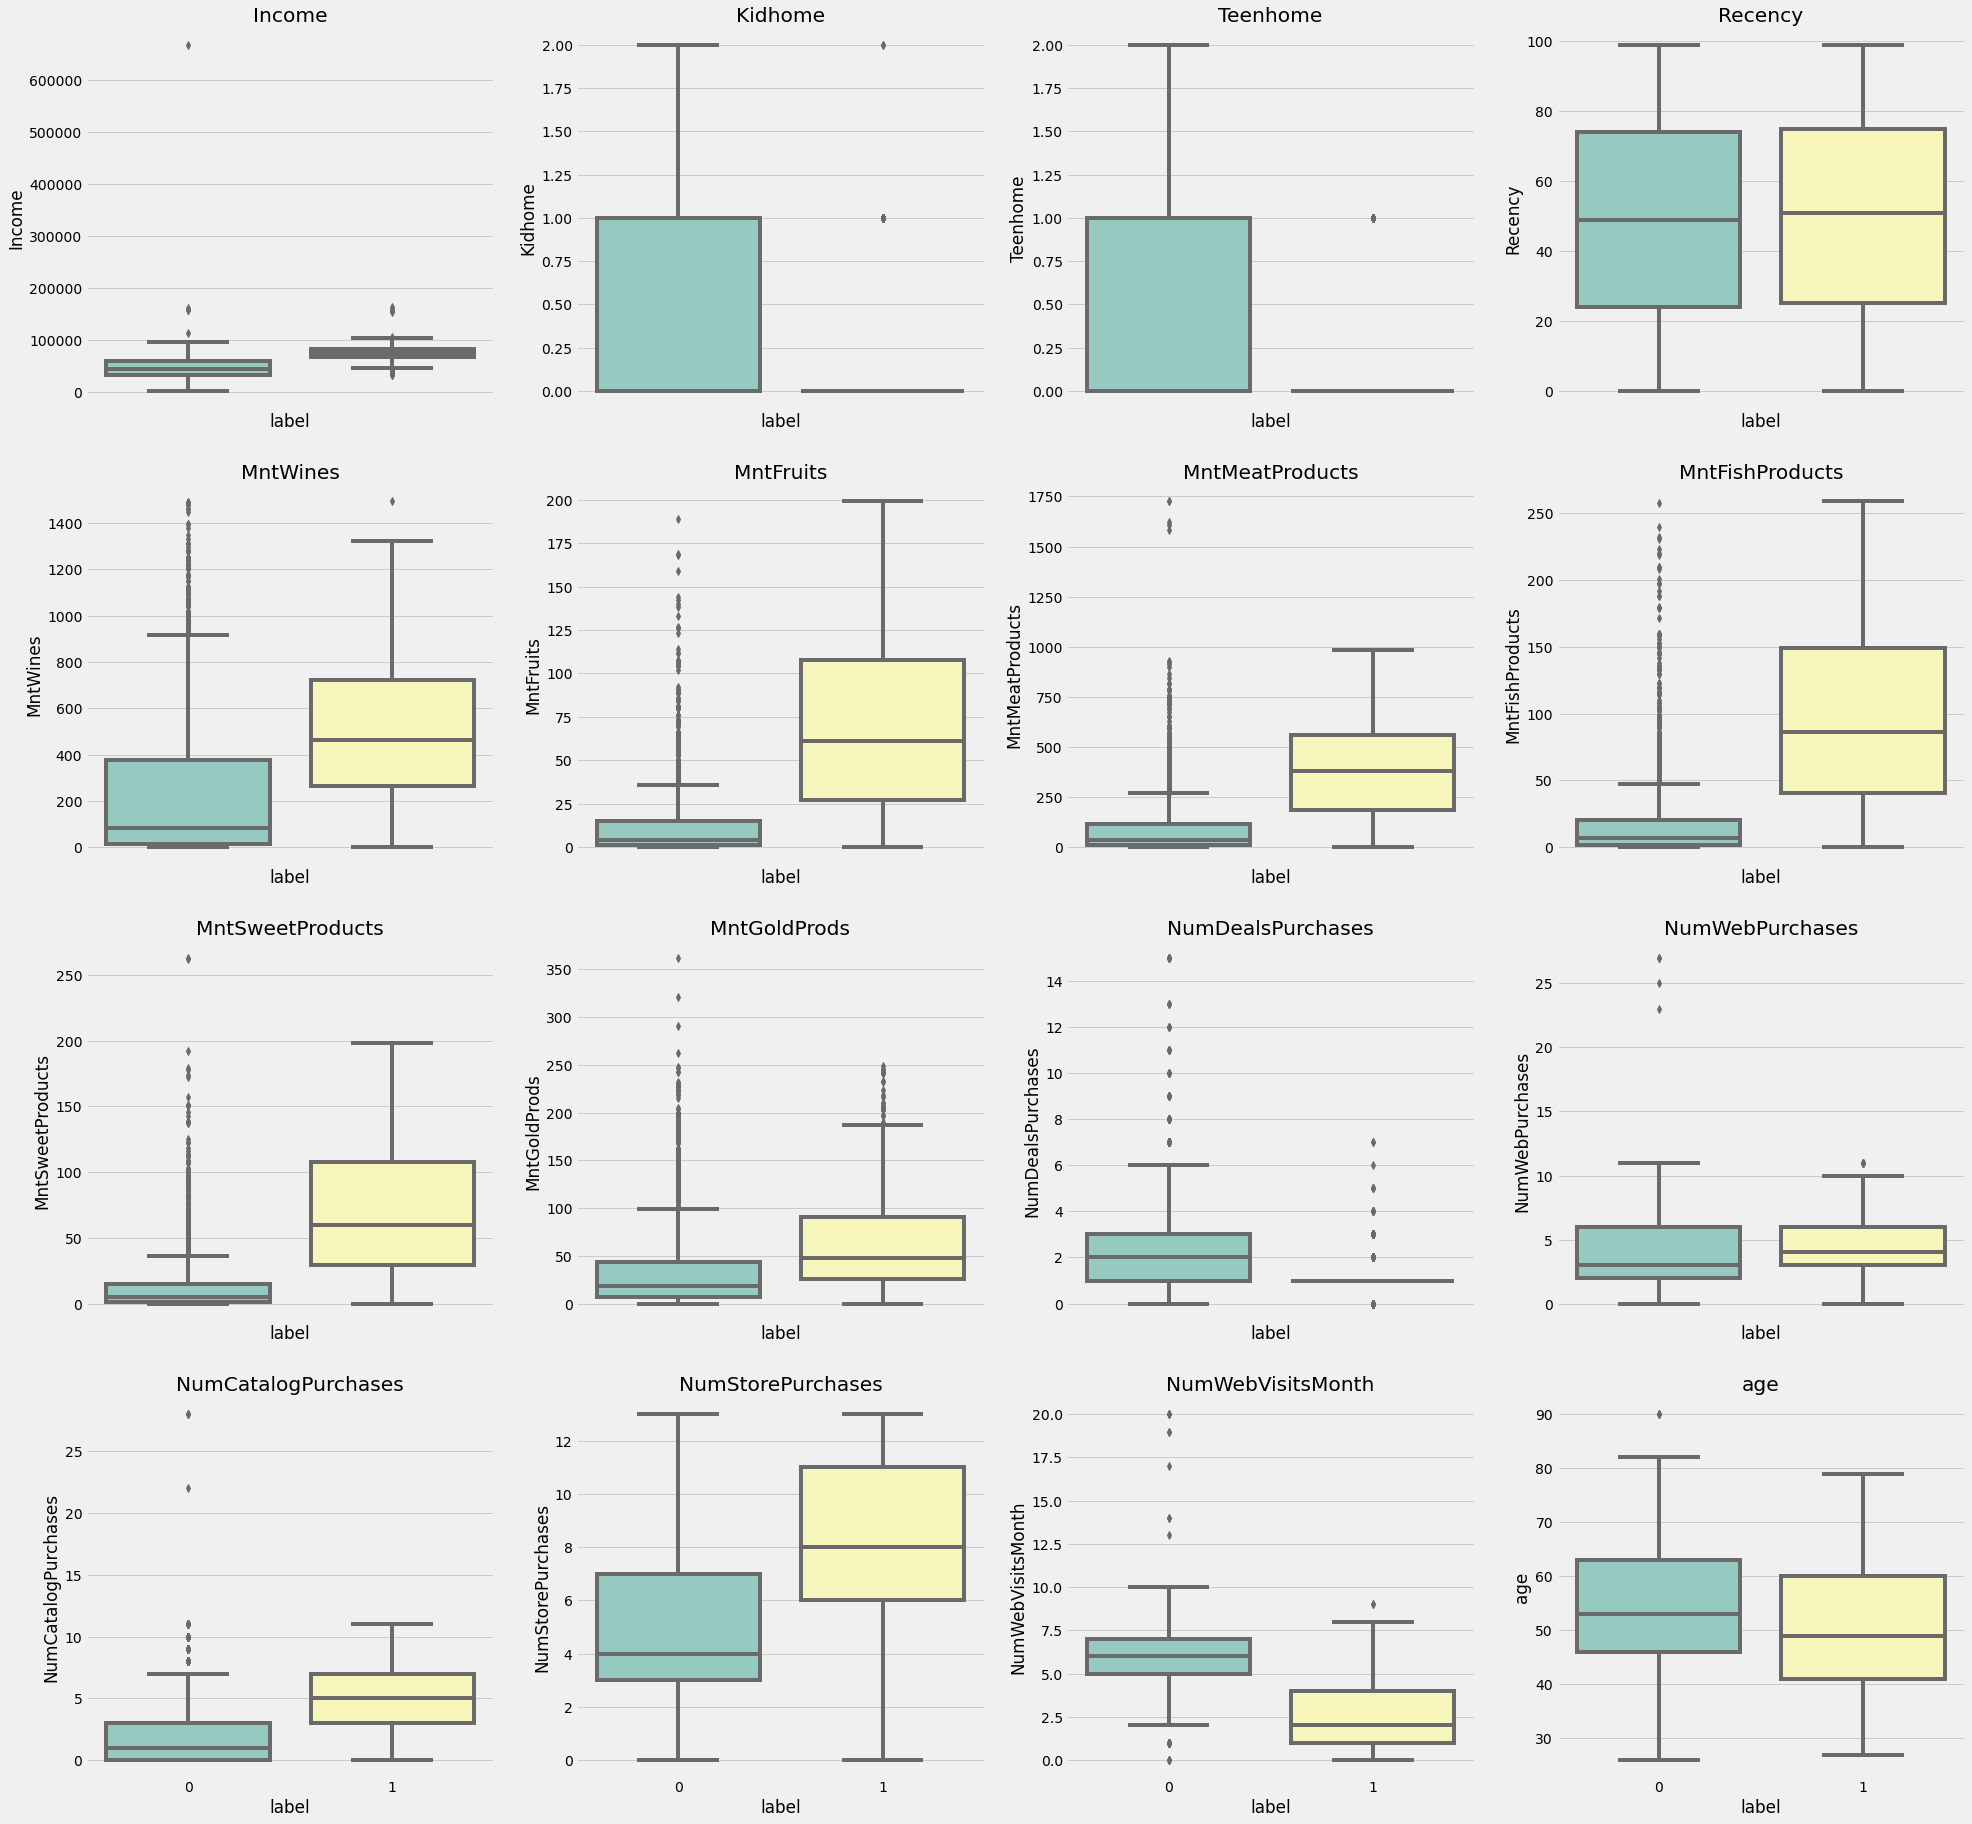

In [143]:
fig, axes = plt.subplots(4,4, figsize=(30,30), sharex=True)
axes = axes.flatten()

for col, ax in zip(col_num, axes):
    sns.boxplot(
        data=df_c,
        x='label',
        y=col,
        palette='Set3',
        ax=ax
    ).set(title='{0}'.format(col))   